## **1. Dataset**

The goal of this coursework is to build an NLP system that can automatically classify text messages as either ham(legit) or spam(non-legit). I will use the SMS Spam Collection dataset which has 5,572 text messages collected from different sources. Each message is manually labelled as “ham” or “spam”. Since SMS spam is a common issue which affects the privacy in different ways and may potentially lead to scams, creating an automated detection system that is efficient will be important. The dataset will be suitable for binary classification and since its text based it allows the comparison of different NLP approaches.

Before applying any machine learning models, I will load the data, check its structure, and explore its characteristics. I will apply basic preprocessing, including the conversion of the text to lowercase, removing punctuation and normalizing the spacings. This will prepare the messages for making them into vectors and the noise in the data. The first exploration will also involve analysing the common words in both ham and spam. This will help understanding the data better, by doing those patterns in each class such as promotional keywords in ham and spam. In general, the dataset offers a solid foundation for comparing traditional NLP methods.

Datasource: UCI Machine Learning Repository - SMS Spam Collection.


In [1]:
import pandas as pd

# Load the SMS Spam dataset
df = pd.read_csv("data/SMSSpamCollection", sep='\t', header=None, names=["label", "message"], encoding="utf-8")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Table 1.1**: Initial inspection of the dataset showing the first five rows.

In [2]:
# Summary
print(df.info())

# Check class distribution
print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
label
ham     4825
spam     747
Name: count, dtype: int64


5,572 entries for both columns with value non-null and a significant imbalance showing 4,825 ‘ham’ and 747 ‘spam messages.

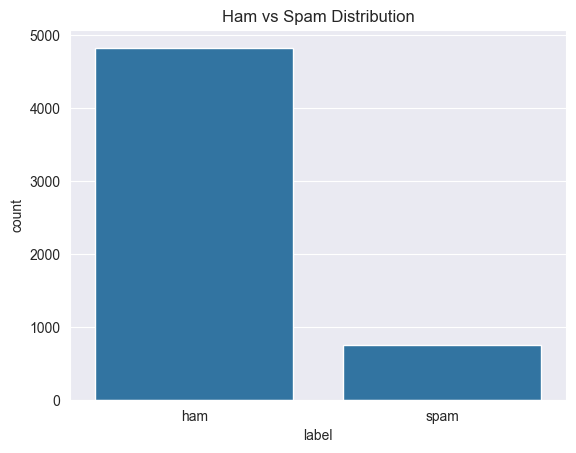

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add message length (optional helpful feature for EDA)
df['message_length'] = df['message'].apply(len)

# Plot class distribution
sns.countplot(data=df, x='label')
plt.title("Ham vs Spam Distribution")
plt.show()

**Figure 1.1**: Class distributions of the messages. The bar chart shows a huge imbalance in the selected dataset, with a significantly higher count of ‘ham’ compared to the ‘spam’ messages.

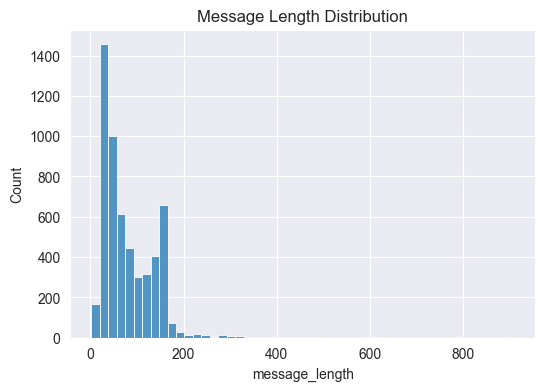

In [4]:
# Plot message length distribution
plt.figure(figsize=(6,4))
sns.histplot(df['message_length'], bins=50)
plt.title("Message Length Distribution")
plt.show()

**Figure 1.2**:
Overall distribution of the message length. The histogram shows that the majority of the messeges are very short with a count of the characters below 200.

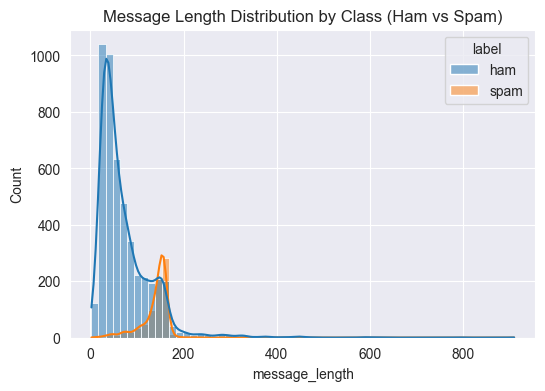

In [5]:
# Class-wise distribution of message length
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='message_length', hue='label', bins=60, kde=True)
plt.title("Message Length Distribution by Class (Ham vs Spam)")
plt.show()

**Figure 1.3**: Compares message length distribution highlighting the key differences between the ‘spam’ messages(orange)  and ‘ham’ messages (blue), which are concentrated at a shorter lengths.

In [6]:
import string
from sklearn.feature_extraction.text import CountVectorizer

df['message_clean'] = df['message'].str.lower()

df['message_clean'] = df['message_clean'].str.replace(f"[{string.punctuation}]", "", regex=True)

df['message_clean'] = df['message_clean'].str.strip()
df['message_clean'] = df['message_clean'].str.replace('\s+', ' ', regex=True)

# Top word frequency analysis
cv = CountVectorizer(stop_words='english')
X_cv = cv.fit_transform(df['message_clean'])

word_counts = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names_out())
df_counts = pd.concat([df['label'], word_counts], axis=1)

spam_words = df_counts[df_counts['label']=="spam"].drop(columns=['label']).sum().sort_values(ascending=False).head(20)
ham_words = df_counts[df_counts['label']=="ham"].drop(columns=['label']).sum().sort_values(ascending=False).head(20)

print("Top Spam Words:\n", spam_words)
print("\nTop Ham Words:\n", ham_words)

Top Spam Words:
 free       216
txt        150
ur         144
mobile     123
text       120
stop       115
claim      113
reply      101
prize       92
just        78
won         73
new         69
send        68
nokia       65
urgent      63
cash        62
win         60
contact     56
service     55
16          51
dtype: int64

Top Ham Words:
 im       451
just     290
ltgt     276
ok       273
dont     263
ur       246
ill      238
know     232
got      232
like     231
come     227
good     224
love     190
day      190
time     189
going    167
want     164
lor      160
home     160
need     157
dtype: int64


The top 20 most frequently used words (excluding stop words)  in the dataset. Spam words include promotional and urgent terms (‘free’ ‘win’ ‘urgent’ ‘prize’) while ‘ham’ words are characterising more casual conversation such as (‘im’ ‘just’ ‘ok’ don’t’)

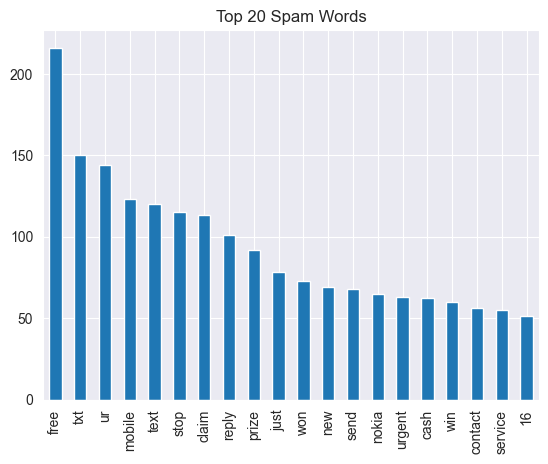

In [7]:
spam_words.plot(kind='bar', title='Top 20 Spam Words')
plt.show()

**Figure 1.4**: Plot shows words related to marketing and urgency. Words like ‘free’ ‘win’ and ‘claim’ are key spam indicators.

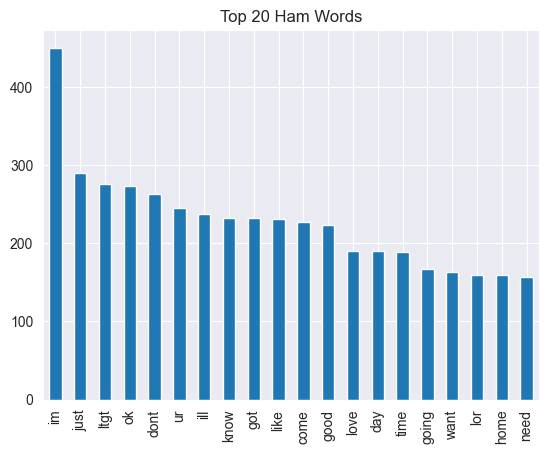

In [8]:
ham_words.plot(kind='bar', title='Top 20 Ham Words')
plt.show()

**Figure 1.5**: Chart confirming the conversational language with ‘im’ ‘just’ and ‘ok’ dominating in the top 20 ‘ham’ words

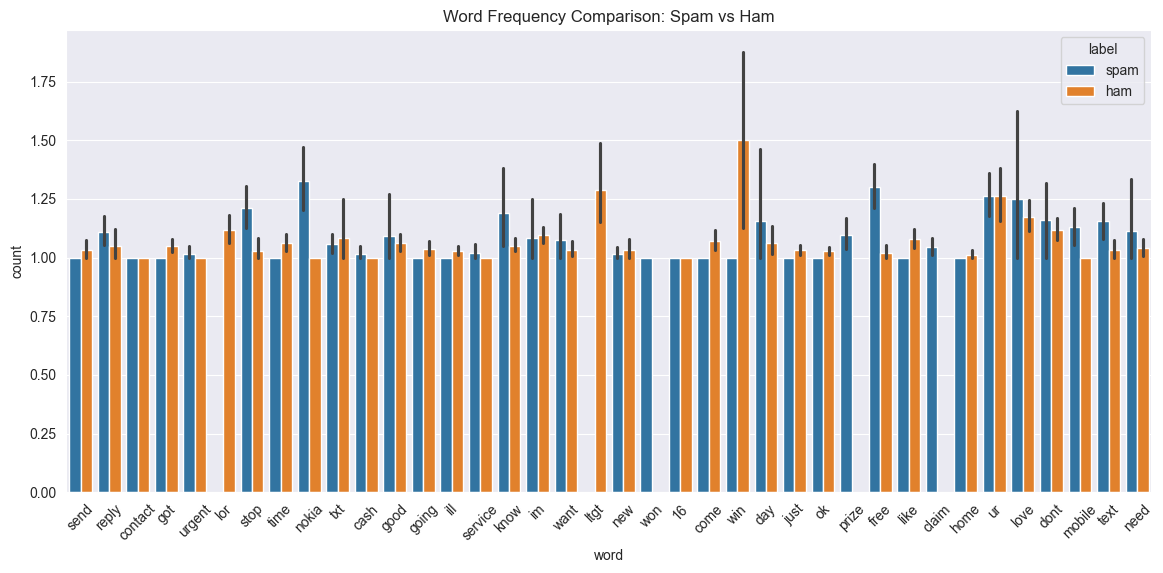

In [9]:
top_words = list(spam_words.index[:20]) + list(ham_words.index[:20])
top_words = list(set(top_words))  # remove duplicates

# Keep only label + these top words
freq_df = df_counts[['label'] + top_words]

# Melt into long format for seaborn
freq_long = freq_df.melt(id_vars='label', var_name='word', value_name='count')

# Keep only non-zero occurrences
freq_long = freq_long[freq_long['count'] > 0]

# Plot: Side-by-side bar chart for word frequencies
plt.figure(figsize=(14,6))
sns.barplot(data=freq_long, x='word', y='count', hue='label')
plt.title("Word Frequency Comparison: Spam vs Ham")
plt.xticks(rotation=45)
plt.show()

**Figure 1.6**: Making a word frequency comparison shows words like ‘won’ and ‘prize' are key discriminators for spam, while common short words are more frequent in 'ham'.